In [86]:
%matplotlib inline 
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import sys 
sys.path.append('../code_general/')
sys.path.append('../code_Boyle/')
import read_model_ID as model
import CRISPR_dCas9_binding_curve_Boyle as mastereq
reload(model);
reload(mastereq)


<module 'CRISPR_dCas9_binding_curve_Boyle' from '../code_Boyle/CRISPR_dCas9_binding_curve_Boyle.pyc'>

In [87]:
def calc_clv_curve(parameters, model_id, mismatch_positions, times ,guide_length):
    mat = mastereq.get_master_equation(parameters=parameters, 
                                        mismatch_positions=mismatch_positions, model_id=model_id, guide_length=guide_length)
    
    initial_condition = np.zeros(guide_length+2)
    initial_condition[0] = 1
    initial_condition.T
    
    probs_uncut = np.zeros(len(times))
    
    for i in range(len(times)):
        matrix_exponent = linalg.expm(+mat*times[i])
        probs = matrix_exponent.dot(initial_condition)
        probs_uncut[i] = np.sum(probs)
        
    return probs_uncut

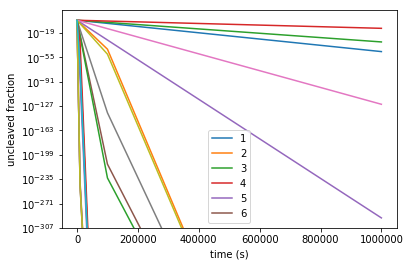

In [88]:
parameters = np.loadtxt('./example-params.txt')
model_id = 'Clv_init_limit_general_energies_v2'
times = [0,1,10,100,1000,10000,100000,1000000]
guide_length = 20

uncut_probs = np.zeros([len(times),20])
plt.figure()

for i in range(20):
    mismatch_positions = [i+1]
    uncut_probs[:,i] = calc_clv_curve(parameters, model_id, mismatch_positions, times, guide_length)
    plt.semilogy(times,uncut_probs[:,i])
    plt.ylabel('uncleaved fraction')
    plt.xlabel('time (s)')
    plt.legend(['1','2','3','4','5','6'])
    



In [89]:
def f(x,k):
    return -k*x

In [91]:
def fit_cleavage_rate(times,probs_uncut,f,treshold = 0.2):
    end = len(times)
    for i in range(len(times)):
        if probs_uncut[i]<treshold:
            end = i
            break
    
    times = times[0:end]
    probs_uncut = probs_uncut[0:end]
    
    ydata = np.log(probs_uncut)
    k, error = curve_fit(f,times,ydata)
    return k
    

Text(0,0.5,'cleavage rate (s^(-1))')

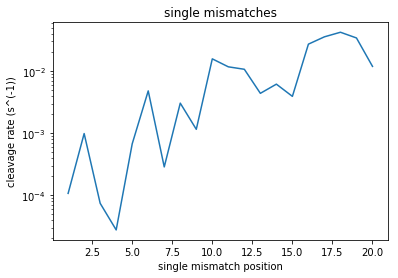

In [92]:
k = np.zeros(20)
for i in range(20):
    probs_uncut = uncut_probs[:,i]
    k[i] = fit_cleavage_rate(times,probs_uncut,f)[0]

    
plt.semilogy(range(1,21),k)
plt.title('single mismatches')
plt.xlabel('single mismatch position')
plt.ylabel('cleavage rate (s^(-1))')
    

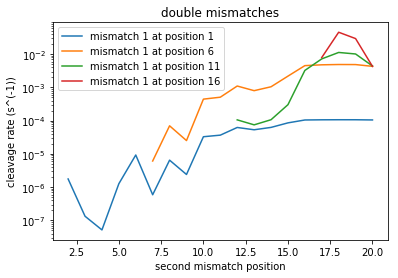

In [96]:
k_matrix = np.zeros([20,20])

for i in range(1,20):
    for j in range(i+1,21):
        mismatch_positions = [i,j]
        uncut_prs = calc_clv_curve(parameters, model_id, mismatch_positions, times, guide_length)
        k_matrix[i-1,j-1] = fit_cleavage_rate(times,uncut_prs,f,0.0001)
        


plt.figure()
plt.semilogy(range(2,21),(k_matrix[0,:])[1:20])
plt.semilogy(range(7,21),(k_matrix[5,:])[6:20])
plt.semilogy(range(12,21),(k_matrix[10,:])[11:20])
plt.semilogy(range(17,21),(k_matrix[15,:])[16:20])

plt.title('double mismatches')
plt.xlabel('second mismatch position')
plt.ylabel('cleavage rate (s^(-1))')
plt.legend(['mismatch 1 at position 1','mismatch 1 at position 6','mismatch 1 at position 11','mismatch 1 at position 16'])
    

In [94]:
len((k_matrix[5,:])[5:20])

15